## Motivação de estudo

A abordagem de **descida de gradiente estocástica com kernels** tem várias vantagens, incluindo:
- **Eficiência computacional**: É mais eficiente que a descida de gradiente completa, especialmente para grandes volumes de dados.
- **Capacidade online**: O modelo pode ser atualizado conforme novos dados chegam, sem precisar de uma retrain completa.
- **Flexibilidade de kernels**: Permite o uso de diferentes funções de kernel (como polinomiais ou Gaussianas) para ajustar relações não-lineares nos dados.

Esses cálculos formam a base para algoritmos eficientes de regressão online em espaços de alta dimensionalidade.

## Descida de Gradiente Estocástica com Kernels Conceitos Matematicos

O problema inicial que se deseja resolver é o da **regressão ridge com kernels**. A função de custo a ser minimizada é:

$$
J = \|y - \phi(X)\phi(w)\|^2 + c\|\phi(w)\|^2
$$

- $y$ são os valores reais (observados).
- $\phi(X)$ é a transformação dos dados de entrada $X$ em um espaço de dimensão superior, realizada por uma função de kernel.
- $\phi(w)$ são os pesos do modelo.
- $c$ é o parâmetro de regularização que ajuda a evitar overfitting, penalizando valores grandes dos pesos $w$.

A regularização ridge faz com que o modelo não se ajuste excessivamente aos dados de treino, permitindo melhor generalização.

### Descida de Gradiente Estocástica (SGD) com Kernels

A **descida de gradiente** é uma técnica de otimização iterativa, e na sua forma estocástica (SGD), o ajuste dos parâmetros do modelo é feito a cada nova observação de dado, o que reduz os custos computacionais comparados à descida de gradiente tradicional, que usaria todo o conjunto de dados a cada iteração.

O **passo de descida de gradiente** para ajustar os pesos $w$ do modelo é dado pela fórmula:

$$
\phi(w) \leftarrow \phi(w) - \eta \frac{1}{2} \frac{\partial J}{\partial \phi(w)}
$$

Aqui:
- $\eta$ é a **taxa de aprendizado** (um valor pequeno que controla o tamanho do passo).
- $\frac{\partial J}{\partial \phi(w)}$ é o gradiente da função de custo em relação aos pesos $w$, que nos indica a direção da maior inclinação da função de custo.

### Estimativa Instantânea do Gradiente

Como estamos lidando com SGD, usamos uma **estimativa instantânea** do gradiente (baseada apenas no dado atual $x_n$ e sua resposta $y_n$) em vez de calcular o gradiente completo sobre todo o conjunto de dados.

Ao calcular a derivada parcial da função de custo, e ignorando momentaneamente a regularização $c$, a regra de atualização do peso $w$ fica assim:



$$
\phi(w_n) = \phi(w_{n-1}) + \eta \left( y_n \phi(x_n) - \phi(x_n) \phi(w_{n-1})^T \phi(x_n) \right)
$$

Este é o passo de ajuste para o peso $w$ no instante $n$. 

- A expressão $y_n \phi(x_n)$ está associada ao erro entre o valor predito pelo modelo e o valor verdadeiro.
- O termo $\phi(x_n) \phi(w_{n-1})^T \phi(x_n)$ representa a previsão feita pelo modelo com base no dado anterior.

Isso pode ser simplificado com o uso do erro instantâneo $e_n$:

$$
e_n = y_n - \phi(x_n)^T \phi(w_{n-1})
$$

Então, a regra de atualização torna-se:

$$
\phi(w_n) = \phi(w_{n-1}) + \eta e_n \phi(x_n)
$$


# Aplicação do algoritmo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
dados = pd.read_csv("data/ca.csv")

C:\Users\kaio\AppData\Local\Temp\ipykernel_34436\2499396848.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv("data/ca.csv")


In [3]:

# Mostra o nome das colunas
print("Nomes das colunas:")
print(dados.columns)

Nomes das colunas:
Index(['Regiao - Sigla', 'Estado - Sigla', 'Municipio', 'Revenda',
       'CNPJ da Revenda', 'Nome da Rua', 'Numero Rua', 'Complemento', 'Bairro',
       'Cep', 'Produto', 'Data da Coleta', 'Valor de Venda', 'Valor de Compra',
       'Unidade de Medida', 'Bandeira'],
      dtype='object')


In [4]:
# Verificando quais colunas contêm valores nulos
colunas_nulas = dados.isnull().sum()

# Filtrando para mostrar apenas as colunas que têm valores nulos
colunas_com_nulos = colunas_nulas[colunas_nulas > 0]

print("Colunas com valores nulos:")
print(colunas_com_nulos)

Colunas com valores nulos:
Numero Rua            605
Complemento        579320
Bairro               1176
Valor de Compra    740945
dtype: int64


In [5]:
dados['Estado - Sigla'].value_counts()

Estado - Sigla
BA    240700
CE    159862
PE    132842
MA     77758
RN     54326
PB     52367
PI     51767
AL     47837
SE     34418
Name: count, dtype: int64

## Pre-Processamento

In [6]:
print("tamanho dos dados antes do pre-processamento:",len(dados))
dados.head(5)


tamanho dos dados antes do pre-processamento: 851877


,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira
0,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,GASOLINA,02/01/2019,"4,49",NaN,R$ / litro,BRANCA
1,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,ETANOL,02/01/2019,"3,33",NaN,R$ / litro,BRANCA
2,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL,02/01/2019,"3,3",NaN,R$ / litro,BRANCA
3,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL S10,02/01/2019,"3,4",NaN,R$ / litro,BRANCA
4,NE,AL,ARAPIRACA,POSTO ARAPIRACA LTDA,12.451.076/0001-12,RUA EXPEDICIONARIOS BRASILEIROS,252,NaN,CENTRO,57300-590,GASOLINA,02/01/2019,"4,699","3,8906",R$ / litro,PETROBRAS DISTRIBUIDORA S.A.


In [7]:
dados['Data da Coleta'] = pd.to_datetime(dados['Data da Coleta'], format='%d/%m/%Y')
dados['Valor de Venda'] = dados['Valor de Venda'].str.replace(',', '.', regex=False).astype(float)
dados = dados[dados['Produto'] == 'GASOLINA']
dados = dados[dados['Estado - Sigla'] == 'CE']
dados = dados[dados['Municipio'] == 'FORTALEZA']

dados.set_index('Data da Coleta', inplace=True)

dados['Ano'] = dados.index.year.astype(float)

dados['Mes'] = dados.index.month.astype(float)

dados = dados.drop(columns=['Valor de Compra'])
dados = dados.drop(columns=['Numero Rua'])
dados = dados.drop(columns=['Complemento'])
dados = dados.drop(columns=['CNPJ da Revenda'])


dados.head()


,Regiao - Sigla,Estado - Sigla,Municipio,Revenda,Nome da Rua,Bairro,Cep,Produto,Valor de Venda,Unidade de Medida,Bandeira,Ano,Mes
Data da Coleta,,,,,,,,,,,,,
2019-01-02,NE,CE,FORTALEZA,DIAS COMERCIO DE DERIVADOS DE PETROLEO LTDA,RODOVIA DOUTOR MENDEL STEINBRUCH,ARACAPE,60765-005,GASOLINA,4.170,R$ / litro,RAIZEN,2019.0,1.0
2019-01-02,NE,CE,FORTALEZA,JOCKEY COMÉRCIO DE COMBUSTÍVEIS LTDA.,AVENIDA LINEU MACHADO,PICI,60520-380,GASOLINA,4.250,R$ / litro,IPIRANGA,2019.0,1.0
2019-01-02,NE,CE,FORTALEZA,F.P. PETROLEO EIRELI,AVENIDA PRESIDENTE COSTA E SILVA,PASSARÉ,60761-190,GASOLINA,4.260,R$ / litro,SP,2019.0,1.0
2019-01-02,NE,CE,FORTALEZA,CENTRO EMPRESARIAL DRA ZUILA ALENCAR BARREIRA ...,AVENIDA JOSE BASTOS,DAMAS,60020-292,GASOLINA,4.240,R$ / litro,IPIRANGA,2019.0,1.0
2019-01-02,NE,CE,FORTALEZA,GG-KIKO COMERCIAL DE COMBUSTIVEIS E SERVIÇOS LTDA,AVENIDA I,CONJUNTO CEARA,60533-670,GASOLINA,4.199,R$ / litro,SP,2019.0,1.0


In [8]:
dados['Municipio'].value_counts()

# Municipios que possuem alto valor
# - ITAPIPOCA
# - CANINDE
# - CRATEUS


Municipio
FORTALEZA    21713
Name: count, dtype: int64

In [9]:
# Manter apenas as colunas 'Municipio' e 'Valor de Venda'
dados = dados[['Municipio', 'Valor de Venda']]
print(len(dados))

# Filtrar os dados para incluir apenas os municípios de Crato, Juazeiro e Barbalha
municipios_desejados = ['MARACANAU', 'FORTALEZA','CAUCAIA']
dados = dados[dados['Municipio'].isin(municipios_desejados)]

# Reamostrar os dados semanalmente, alinhando as datas ao início do intervalo
dados = dados.groupby('Municipio').resample('W-MON', label='left').mean()

# Preencher os valores NaN com o valor anterior para evitar perda de dados
dados = dados.groupby('Municipio').fillna(method='ffill')

# Resetar o índice e reconfigurar a 'Data da Coleta' como índice
dados = dados.reset_index()
dados.set_index('Data da Coleta', inplace=True)

# Ordenar os dados pelo índice
dados = dados.sort_index()

# Adicionar as colunas 'Ano' e 'Mes'
dados['Ano'] = dados.index.year.astype(float)
dados['Mes'] = dados.index.month.astype(float)


21713


C:\Users\kaio\AppData\Local\Temp\ipykernel_34436\3256400274.py:13: FutureWarning: DataFrameGroupBy.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados = dados.groupby('Municipio').fillna(method='ffill')
C:\Users\kaio\AppData\Local\Temp\ipykernel_34436\3256400274.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dados = dados.groupby('Municipio').fillna(method='ffill')


In [10]:
dados['Municipio'].value_counts()

Municipio
FORTALEZA    261
Name: count, dtype: int64

In [11]:
print("tamanho dos dados após pre-processamento:",len(dados))
dados.head(5)

tamanho dos dados após pre-processamento: 261


,Municipio,Valor de Venda,Ano,Mes
Data da Coleta,,,,
2018-12-31,FORTALEZA,4.293604,2018.0,12.0
2019-01-07,FORTALEZA,4.216802,2019.0,1.0
2019-01-14,FORTALEZA,4.216802,2019.0,1.0
2019-01-21,FORTALEZA,4.172050,2019.0,1.0
2019-01-28,FORTALEZA,4.126631,2019.0,1.0


In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Definindo colunas categóricas e numéricas
categorical_features = ['Municipio']
numeric_features = ['Ano', 'Mes','Valor de Venda']

# Separando as features e o target
X = dados[categorical_features + numeric_features]
y = dados['Valor de Venda']

# Determinando os tamanhos dos conjuntos de treino, validação e teste
n = len(X)
train_size = int(n * 0.72)  # 72% para treino
val_size = int(n * 0.18)    # 18% para validação
test_size = n - train_size - val_size  # 10% para teste

# Dividindo os dados
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# Configurando o pré-processador para aplicar OneHotEncoding apenas nas colunas categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Mantém as features numéricas na escala original
)

# Criando o pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicando o pipeline aos dados de treino e transformando
X_train_transformed = pipeline.fit_transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)

# Obtendo os nomes das colunas após o OneHotEncoding e mantendo as colunas numéricas
categorical_feature_names = pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_features)
all_feature_names = list(categorical_feature_names) + numeric_features

# Convertendo as matrizes para DataFrames e ajustando os índices para frequência diária
X_train_transformed_df = pd.DataFrame(X_train_transformed, 
                                      columns=all_feature_names,
                                      index=X_train.index)

X_val_transformed_df = pd.DataFrame(X_val_transformed, 
                                    columns=all_feature_names,
                                    index=X_val.index)

X_test_transformed_df = pd.DataFrame(X_test_transformed, 
                                     columns=all_feature_names,
                                     index=X_test)

# Verificando os tamanhos dos conjuntos e o ajuste de índices
print("Treinamento:", X_train_transformed_df.shape)
print("Validação:", X_val_transformed_df.shape)
print("Teste:", X_test_transformed_df.shape)

'''# Adicionando a coluna 'Valor de Venda' aos dados de treino e validação originais
dados_treino = X_train.copy()
dados_val = X_val.copy()

dados_treino['Valor de Venda'] = y_train
dados_val['Valor de Venda'] = y_val'''


Treinamento: (187, 4)
Validação: (46, 4)
Teste: (28, 4)


"# Adicionando a coluna 'Valor de Venda' aos dados de treino e validação originais\ndados_treino = X_train.copy()\ndados_val = X_val.copy()\n\ndados_treino['Valor de Venda'] = y_train\ndados_val['Valor de Venda'] = y_val"

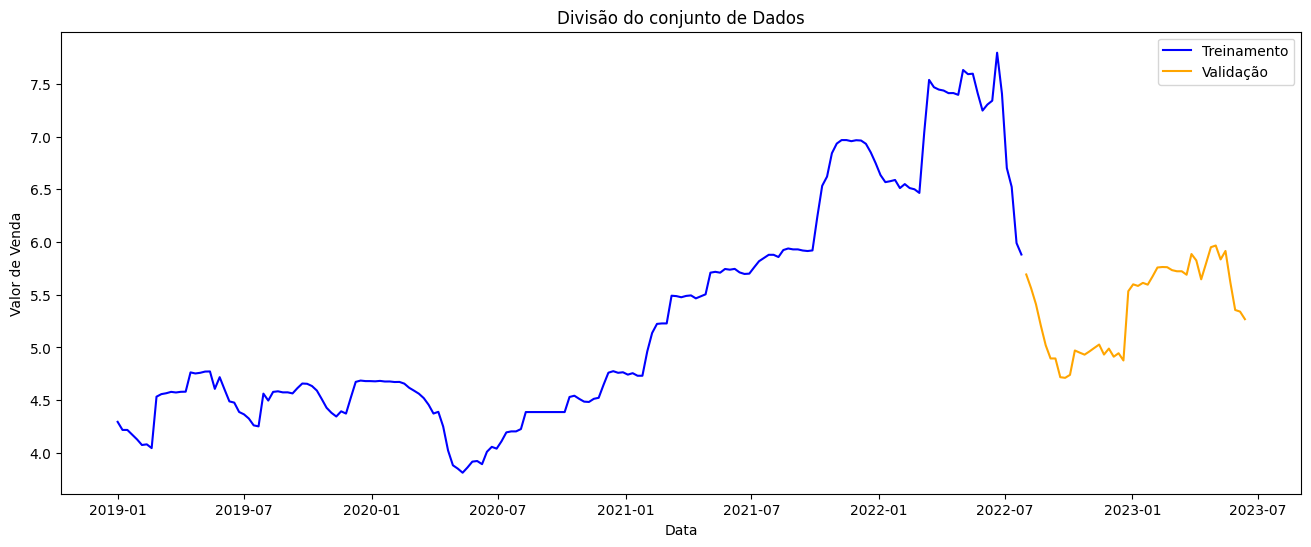

In [13]:
plt.figure(figsize=(16,6))

plt.title("Divisão do conjunto de Dados")

plt.plot(y_train,label='Treinamento', color='blue')
plt.plot(y_val,label='Validação', color='orange')

plt.xlabel("Data")
plt.ylabel("Valor de Venda")
plt.legend()

plt.show()

# Plota mais uma vez a serie com um ponto a mais  ou em validação ou em treinamento
# colocar linha vertical pra distinguir teste e validação

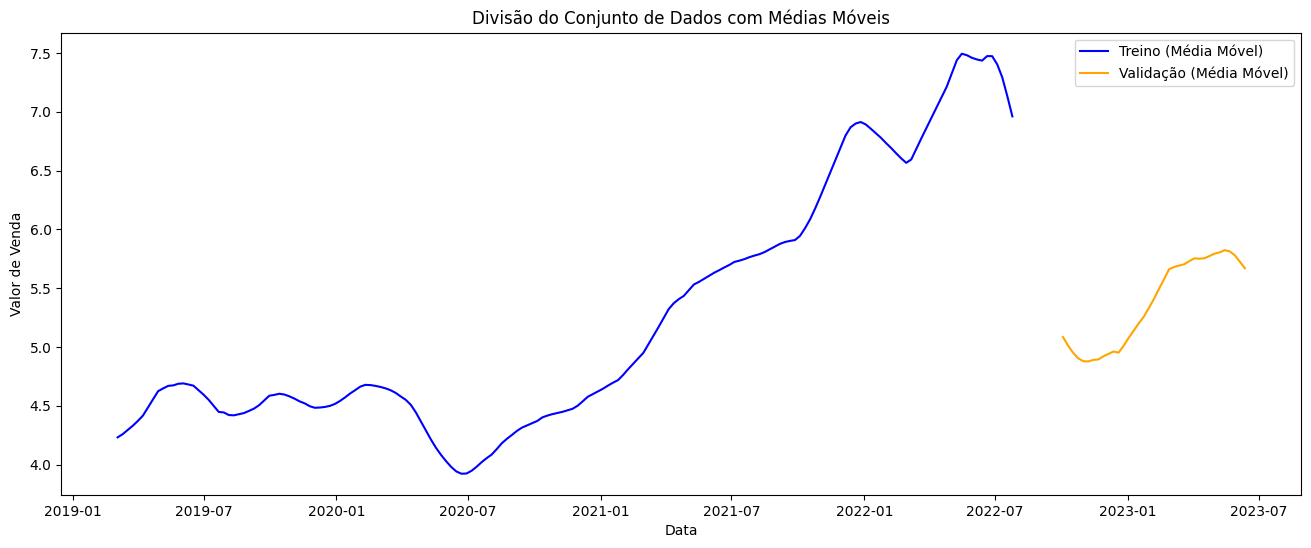

In [14]:
# Aplicando médias móveis com uma janela de 10 períodos (por exemplo)
y_train_rolling = y_train.rolling(window=10).mean()
y_val_rolling = y_val.rolling(window=10).mean()

# Plotando as médias móveis
plt.figure(figsize=(16, 6))

plt.title("Divisão do Conjunto de Dados com Médias Móveis")

plt.plot(y_train_rolling, label='Treino (Média Móvel)', color='blue')
plt.plot(y_val_rolling, label='Validação (Média Móvel)', color='orange')

plt.xlabel("Data")
plt.ylabel("Valor de Venda")
plt.legend()

plt.show()


# log linear e usar linear 
# depois pegar o residuo do modelo linear e usar na arvore de decisao

## Análise de Autocorrelação

<function matplotlib.pyplot.show(close=None, block=None)>

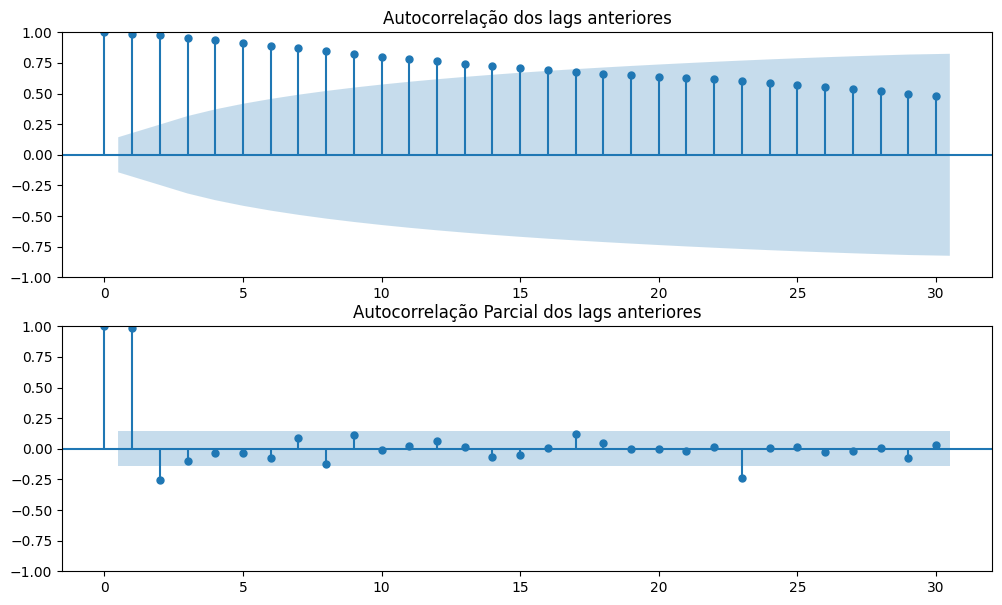

In [15]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(211)
fig = plot_acf(X_train['Valor de Venda'], lags=30, ax=ax1)
ax1.set_title("Autocorrelação dos lags anteriores")

ax2 = fig.add_subplot(212)
fig = plot_pacf(X_train['Valor de Venda'], lags=30, ax=ax2)
ax2.set_title("Autocorrelação Parcial dos lags anteriores")

plt.show


Lags Significantes: [1, 2, 6, 7, 8, 9, 17, 23, 28]


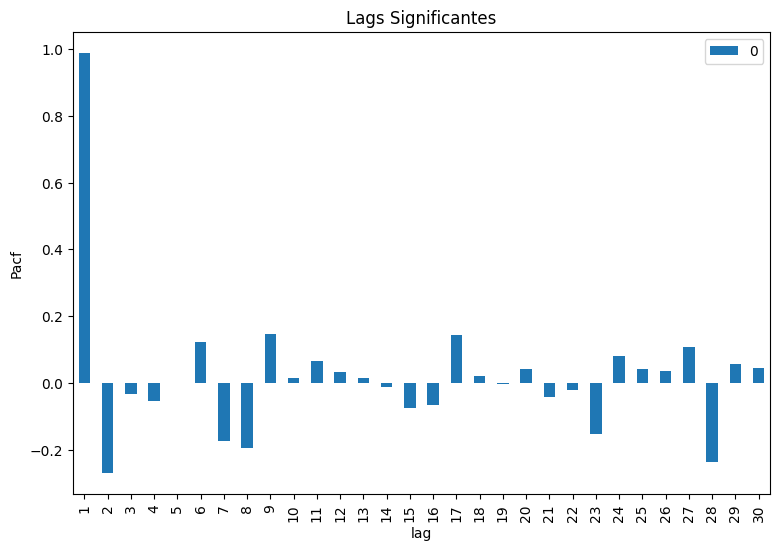

In [16]:
from statsmodels.tsa.stattools import pacf

def getSignificantLags(y, nLags = 5, alpha=0.05):
    Pacf, Pacf_intervalos =  pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(Pacf)[1:].plot(kind='bar', figsize=(9,6), legend='pacf valores',
                               xlabel='lag', ylabel='Pacf');
    significantLags = []
    for i in range(1, len(Pacf)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if Pacf[i] < Pacf_intervalos[i][0] - Pacf[i] or Pacf[i] > Pacf_intervalos[i][1] - Pacf[i]:
            significantLags.append(i)
    print('Lags Significantes:', significantLags)
    return significantLags

DT_significantLags = getSignificantLags(dados['Valor de Venda'], nLags = 30, alpha=0.05)
plt.title("Lags Significantes")
plt.show()

## Modelagem

In [17]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
def TheilU(y_true, y_pred):
    fResiduals2 = y_true[1:].subtract(y_pred[1:])
    fResiduals2 = fResiduals2.multiply(fResiduals2)
    rwForecasts = y_true.shift(1)
    rwResiduals2 = y_true[1:].subtract(rwForecasts[1:])
    rwResiduals2 = rwResiduals2.multiply(rwResiduals2)
    theil = fResiduals2.sum()/rwResiduals2.sum()
    return theil

models_label_r = []
df_teste  = pd.DataFrame()
def ResidualForModels(models,y_pred): 
    for model in models:
        formalism = type(model).__name__
        models_label_r.append(formalism)
        y_pred_t = y_pred
        df_teste[formalism] = y_pred_t
    return df_teste

models_label = []
models_MAPE = []
models_MAE = []
models_R2 = []
models_theil = []

def computeAccuracyModels(models,y_pred): 
    for model in models:
        formalism = type(model).__name__
        models_label.append(formalism)
        y_pred_test = y_pred
        models_MAE.append(mean_absolute_error(y_true=y_val.values.ravel(), y_pred=y_pred_test))
        # models_theil.append(TheilU(y_true=y_val.values.ravel(), y_pred=y_pred_test))
        models_MAPE.append(mean_absolute_percentage_error(y_true=y_val.values.ravel(), y_pred=y_pred_test))
        models_R2.append(r2_score(y_true=y_val.values.ravel(), y_pred=y_pred_test))
        
    df = pd.DataFrame({'model': models_label, 
                       'MAE': models_MAE,
                       'MAPE': models_MAPE,
                       'R2': models_R2,
                       # 'theil': models_theil
                       })
    print(" --------------------------- Medidas de Erro para os Modelos  --------------------------- ") 
    print(df.sort_values(by='MAE', ascending = True))
    

In [18]:
def appendLagVariables(y, significantLags, df, dropna=True, previousData=None):
    prefix = y.replace(')', '')
    df = df.copy()  # Fazendo uma cópia para evitar modificar o original
    x = df[y]

    # Se houver dados anteriores (ex.: dados de treino para preencher lags na validação)
    if previousData is not None:
        x = pd.concat([previousData[y], x])
    
    # Criando as variáveis de lag
    for lag in significantLags:
        varNm = prefix + '-' + str(lag) + ')'
        df[varNm] = x.shift(lag).iloc[len(previousData) if previousData is not None else 0:]
    
    if dropna:
        # Dropar apenas linhas onde os NaN estão nas colunas de lag, preservando a coluna 'Valor de Venda'
        lag_columns = [prefix + '-' + str(lag) + ')' for lag in significantLags]
        df.dropna(subset=lag_columns, inplace=True)
        
    return df


# Usar a função para gerar as variáveis de lag e atribuir ao DataFrame X_train_transformed_df
# Geração das variáveis de lag para o treino
X_train_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_train_transformed_df, 
    dropna=True
)

# Geração das variáveis de lag para a validação, usando os dados de treino como `previousData`
X_val_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_val_transformed_df, 
    previousData=X_train_transformed_df,
    dropna=True
)

# Geração das variáveis de lag para o teste, usando os dados de validação como `previousData`
X_test_transformed_df = appendLagVariables(
    y='Valor de Venda', 
    significantLags=DT_significantLags, 
    df=X_test_transformed_df, 
    previousData=X_val_transformed_df,
    dropna=True
)

# Separando a variável alvo do treino, validação e teste
y_train = X_train_transformed_df['Valor de Venda']
y_val = X_val_transformed_df['Valor de Venda']
y_test = X_test_transformed_df['Valor de Venda']

# Removendo a coluna de 'Valor de Venda' dos conjuntos de treino, validação e teste
X_train_transformed_df = X_train_transformed_df.drop(columns=['Valor de Venda','Municipio_FORTALEZA'])
X_val_transformed_df = X_val_transformed_df.drop(columns=['Valor de Venda','Municipio_FORTALEZA'])
X_test_transformed_df = X_test_transformed_df.drop(columns=['Valor de Venda','Municipio_FORTALEZA'])




In [19]:
print("Tamanho do dados após o pipeline\n")
print("Treinamento:", len(X_train_transformed_df))
print("Validação:", len(X_val_transformed_df))

Tamanho do dados após o pipeline

Treinamento: 159
Validação: 46


* trabalhar somente com fortaleza
* usar arvore de decisao para modelar residuos de outros modelos

In [20]:
X_val_transformed_df.head(5)

,Ano,Mes,Valor de Venda-1),Valor de Venda-2),Valor de Venda-6),Valor de Venda-7),Valor de Venda-8),Valor de Venda-9),Valor de Venda-17),Valor de Venda-23),Valor de Venda-28)
Data da Coleta,,,,,,,,,,,
2022-08-01,2022.0,8.0,5.881449,5.990000,7.796478,7.341287,7.304466,7.247549,7.437358,6.500396,6.577197
2022-08-08,2022.0,8.0,5.692043,5.881449,7.407333,7.796478,7.341287,7.304466,7.412816,6.465900,6.588824
2022-08-15,2022.0,8.0,5.561061,5.692043,6.701782,7.407333,7.796478,7.341287,7.413704,7.038862,6.511782
2022-08-22,2022.0,8.0,5.409065,5.561061,6.523366,6.701782,7.407333,7.796478,7.396750,7.538485,6.549800
2022-08-29,2022.0,8.0,5.206753,5.409065,5.990000,6.523366,6.701782,7.407333,7.632683,7.469253,6.512200


## Gradient Descendent Online in ridge regression

In [21]:
X_train_transformed_df.dtypes

Ano                   float64
Mes                   float64
Valor de Venda-1)     float64
Valor de Venda-2)     float64
Valor de Venda-6)     float64
Valor de Venda-7)     float64
Valor de Venda-8)     float64
Valor de Venda-9)     float64
Valor de Venda-17)    float64
Valor de Venda-23)    float64
Valor de Venda-28)    float64
dtype: object

C:\Users\kaio\AppData\Local\Temp\ipykernel_34436\3528288685.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  self.X_train_tensor = torch.tensor([x_new], dtype=torch.float32)  # Inicializa o conjunto de treino


Previsões para os dados combinados: [3.74159836769104, 3.656968832015991, 3.6080892086029053, 3.6930856704711914, 3.7246761322021484, 3.6844639778137207, 3.6616673469543457, 3.59104323387146, 3.717806816101074, 3.7348906993865967, 3.8455734252929688, 3.9207589626312256, 3.858450412750244, 3.867563247680664, 3.8348231315612793, 3.810499668121338, 3.7211177349090576, 3.675969362258911, 3.6488969326019287, 3.7034664154052734, 3.558316946029663, 3.570087432861328, 3.5700206756591797, 3.5277228355407715, 3.5052995681762695, 3.7388229370117188, 3.762725353240967, 3.8393352031707764, 3.8832335472106934, 4.032565116882324, 4.1132354736328125, 4.0864057540893555, 4.087070465087891, 4.149637222290039, 4.123297691345215, 4.116142272949219, 4.084063529968262, 4.077650547027588, 4.100080490112305, 4.058667182922363, 3.9898478984832764, 3.8536887168884277, 3.7261428833007812, 3.639709949493408, 3.594343662261963, 3.5421433448791504, 3.5074636936187744, 3.4080371856689453, 3.2991764545440674, 3.23520

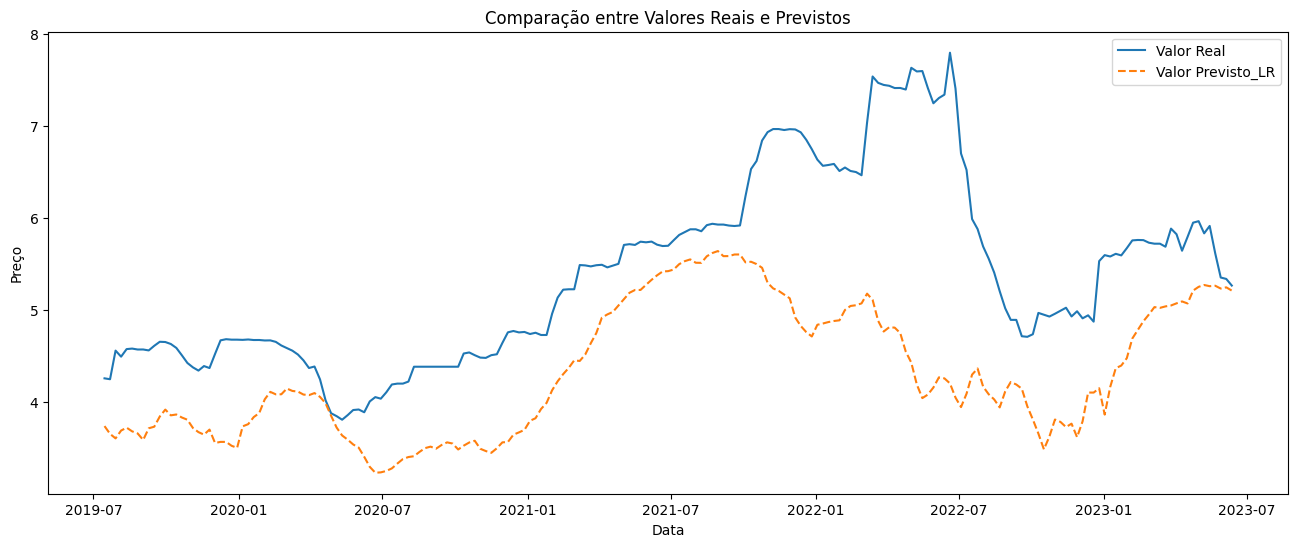

primeira muito boa muito top


In [22]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Função kernel (RBF ajustado com a equação 21.39)
def Ridgkernel(x1, x2, sigma_0=1.0, l=1.0):
    diff = np.array(x1, dtype=float) - np.array(x2, dtype=float)
    return sigma_0**2 * np.exp(-np.dot(diff, diff) / (2 * l**2))

# Implementação da Regressão Ridge com SGD para Séries Temporais Online usando PyTorch
class RidgeSGDKernelTorch:
    def __init__(self, eta=0.01, c=1.0, sigma=1.0):
        self.eta = eta  # taxa de aprendizado
        self.c = c  # parâmetro de regularização
        self.sigma = sigma  # parâmetro do kernel
        self.alpha = None  # pesos (serão inicializados depois)
        self.X_train_tensor = None  # histórico de amostras de treino

    def partial_fit(self, x_new, y_new):
        if self.X_train_tensor is None:
            self.X_train_tensor = torch.tensor([x_new], dtype=torch.float32)  # Inicializa o conjunto de treino
            self.alpha = torch.zeros(1, dtype=torch.float32)  # Inicializa os pesos com um único valor
        else:
            self.X_train_tensor = torch.vstack([self.X_train_tensor, torch.tensor(x_new, dtype=torch.float32)])  # Adiciona nova amostra
            self.alpha = torch.cat([self.alpha, torch.zeros(1)])  # Adiciona um peso para a nova amostra

        n_samples = self.X_train_tensor.shape[0]

        # Calcular a previsão
        if n_samples > 1:
            kernels = torch.exp(-torch.norm(self.X_train_tensor[:n_samples - 1] - self.X_train_tensor[n_samples - 1], dim=1) ** 2 / (2 * self.sigma ** 2))
            pred_n = torch.dot(self.alpha[:n_samples - 1], kernels)
        else:
            pred_n = 0

        # Calcular o erro
        error = y_new - pred_n

        # Atualizar os pesos conforme a equação 21.33:
        self.alpha[:n_samples - 1] = (1 - self.eta * self.c) * self.alpha[:n_samples - 1]
        self.alpha[n_samples - 1] = self.eta * error

    def predict(self, x_new):
        # Prever com base nos dados de treino atuais
        x_new_tensor = torch.tensor(x_new, dtype=torch.float32)
        n_samples = self.X_train_tensor.shape[0]

        if n_samples > 1:
            kernels = torch.exp(-torch.norm(self.X_train_tensor[:n_samples - 1] - x_new_tensor, dim=1) ** 2 / (2 * self.sigma ** 2))
            prediction = torch.dot(self.alpha[:n_samples - 1], kernels)
            return prediction.item()
        else:
            return 0.0

# Certifique-se de que os dados sejam numéricos
X_train_transformed_df = X_train_transformed_df.apply(pd.to_numeric, errors='coerce').dropna()
y_train = pd.to_numeric(y_train, errors='coerce').dropna()

# Combinar os dados de treino e validação
X_combined_df = pd.concat([X_train_transformed_df, X_val_transformed_df])
y_combined = pd.concat([y_train, y_val])

# Inicializar o StandardScaler para padronizar as features
scaler = StandardScaler()

# Ajustar o scaler aos dados combinados e transformar as features
X_combined_scaled = scaler.fit_transform(X_combined_df)

# Criar o modelo
ridge_sgd_torch = RidgeSGDKernelTorch(eta=0.08, c=0.12, sigma=4)

# Treinar o modelo de forma online com os dados combinados e padronizados
for x_new, y_new in zip(X_combined_scaled, y_combined):
    ridge_sgd_torch.partial_fit(x_new, y_new)

# Prever com os dados combinados padronizados
y_pred_combined = []
for x_combined in X_combined_scaled:
    prediction = ridge_sgd_torch.predict(x_combined)
    y_pred_combined.append(prediction)

# Previsões indexadas
y_combined_indexed = pd.Series(y_pred_combined, index=y_combined.index)

print("Previsões para os dados combinados:", y_pred_combined)
plt.figure(figsize=(16, 6))
plt.plot(y_combined, label='Valor Real')
plt.plot(y_combined_indexed, label='Valor Previsto_LR', linestyle='--')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()
print("primeira muito boa muito top")

Melhores parâmetros encontrados: OrderedDict([('c', 0.06966665966421981), ('eta', 0.15815381707455547), ('sigma', 7.0)])
Melhor score (negativo do MSE): -0.8734391920362204
com bayes search
Previsões comparadas com os valores reais:
                 Valor Real  Previsão
Data da Coleta                      
2019-07-15        4.260180  4.629567
2019-07-22        4.250536  4.586156
2019-07-29        4.561330  4.560715
2019-08-05        4.495600  4.596999
2019-08-12        4.577866  4.613442
...                    ...       ...
2023-05-15        5.915319  5.252582
2023-05-22        5.618298  5.254252
2023-05-29        5.355106  5.239162
2023-06-05        5.339787  5.219622
2023-06-12        5.267872  5.203056

[205 rows x 2 columns]


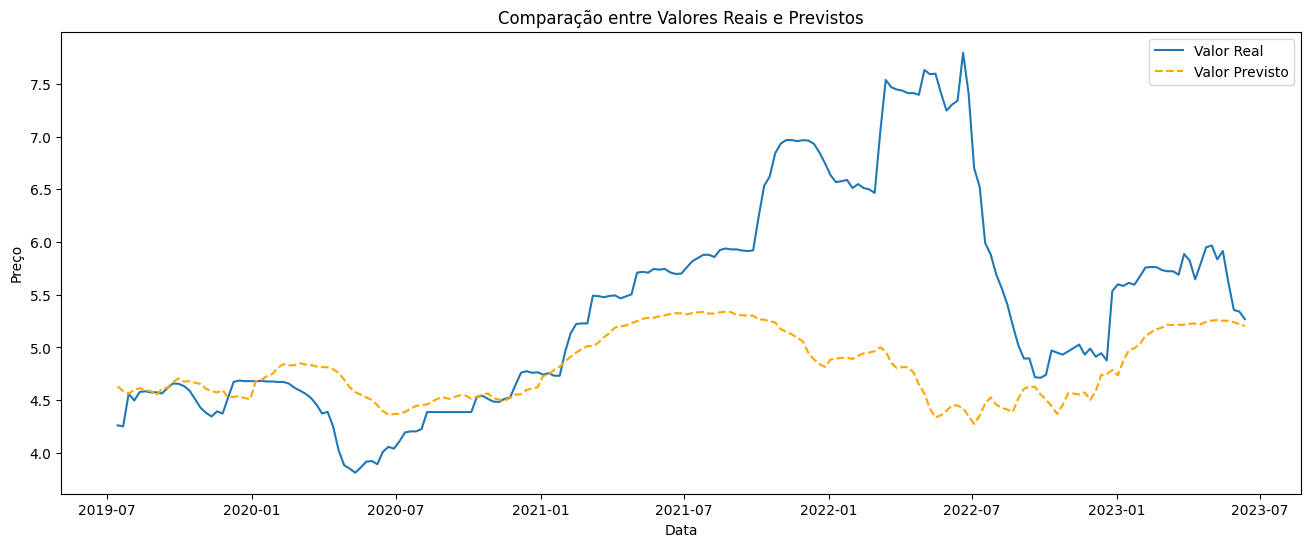

In [23]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error

# Função kernel Gaussiano (RBF Kernel)
def gaussian_kernel(x1, x2, sigma):
    return torch.exp(-torch.norm(x1 - x2) ** 2 / (2 * sigma ** 2))

# Classe ajustada para busca Bayesiana
class RidgeSGDKernelTorch(BaseEstimator, RegressorMixin):
    def __init__(self, eta=0.01, c=1.0, sigma=1.0):
        self.eta = eta
        self.c = c
        self.sigma = sigma
        self.alpha = None
        self.X_train_tensor = None

    def fit(self, X, y):
        # Inicializa variáveis para treinamento com SGD online
        self.alpha = None
        self.X_train_tensor = None

        for x_new, y_new in zip(X, y):
            self.partial_fit(x_new, y_new)
        return self

    def partial_fit(self, x_new, y_new):
        if self.X_train_tensor is None:
            self.X_train_tensor = torch.tensor([x_new], dtype=torch.float32)
            self.alpha = torch.zeros(1, dtype=torch.float32)
        else:
            self.X_train_tensor = torch.vstack([self.X_train_tensor, torch.tensor(x_new, dtype=torch.float32)])
            self.alpha = torch.cat([self.alpha, torch.zeros(1)])

        n_samples = self.X_train_tensor.shape[0]

        if n_samples > 1:
            kernels = torch.tensor([gaussian_kernel(self.X_train_tensor[i], self.X_train_tensor[-1], self.sigma)
                                    for i in range(n_samples - 1)])
            pred_n = torch.dot(self.alpha[:n_samples - 1], kernels)
        else:
            pred_n = 0

        error = y_new - pred_n
        
# prever antes do fit, e com o fit usar a previsao para atualizar o novo dado

        self.alpha[:n_samples - 1] = (1 - self.eta * self.c) * self.alpha[:n_samples - 1]
        self.alpha[n_samples - 1] = self.eta * error

    def predict(self, X):
        predictions = []
        for x_new in X:
            x_new_tensor = torch.tensor(x_new, dtype=torch.float32)
            n_samples = self.X_train_tensor.shape[0]

            if n_samples > 1:
                kernels = torch.tensor([gaussian_kernel(self.X_train_tensor[i], x_new_tensor, self.sigma)
                                        for i in range(n_samples - 1)])
                prediction = torch.dot(self.alpha[:n_samples - 1], kernels)
                predictions.append(prediction.item())
            else:
                predictions.append(0.0)
        return np.array(predictions)

# Padronizar os dados
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined_df)
# Ajustar o espaço de busca Bayesiana com valores próximos aos melhores parâmetros
# Ajustar o espaço de busca Bayesiana com valores próximos aos melhores parâmetros fornecidos
param_space = {
    'eta': Real(0.07, 1.5, prior='log-uniform'),   # restringindo ao redor de 0.08
    'c': Real(0.05, 0.15, prior='log-uniform'),      # restringindo ao redor de 0.12
    'sigma': Real(5.5, 7.0, prior='log-uniform')    # restringindo ao redor de 4
}

# Configurar busca Bayesiana
bayes_search = BayesSearchCV(
    RidgeSGDKernelTorch(),
    param_space,
    n_iter=30,  # número de iterações da busca
    cv=3,       # número de folds de validação cruzada
    scoring='neg_mean_squared_error',  # usar MSE como métrica
    n_jobs=-1
)

# Executar busca Bayesiana nos dados de treino
bayes_search.fit(X_combined_scaled, y_combined)

# Melhor conjunto de parâmetros encontrados
print("Melhores parâmetros encontrados:", bayes_search.best_params_)
print("Melhor score (negativo do MSE):", bayes_search.best_score_)

print("com bayes search")

# Pegar o modelo com os melhores parâmetros encontrados pela busca Bayesiana
best_model = bayes_search.best_estimator_

# Fazer previsões usando o modelo otimizado
y_pred_combined = best_model.predict(X_combined_scaled)

# Converter as previsões em uma série indexada para comparação com os valores reais
y_pred_combined_series = pd.Series(y_pred_combined, index=y_combined.index)

# Exibir as previsões e os valores reais para comparação
predictions_df = pd.DataFrame({
    'Valor Real': y_combined,
    'Previsão': y_pred_combined_series
})

print("Previsões comparadas com os valores reais:\n", predictions_df)


import matplotlib.pyplot as plt

# Plotar valores reais vs. previsões otimizadas
plt.figure(figsize=(16, 6))
plt.plot(y_combined, label='Valor Real')
plt.plot(y_pred_combined_series, label='Valor Previsto', linestyle='--', color='orange')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()


# modelas serie original com randon walk, este randon walk gerará residuos, esta series de residuos com randon walk eu uso 
# o modelo de gradiente descendente online 
# com isto terei uma serie de previsao dos residuos e ai uso o boosting

Previsões de Random Walk para o conjunto de validação:


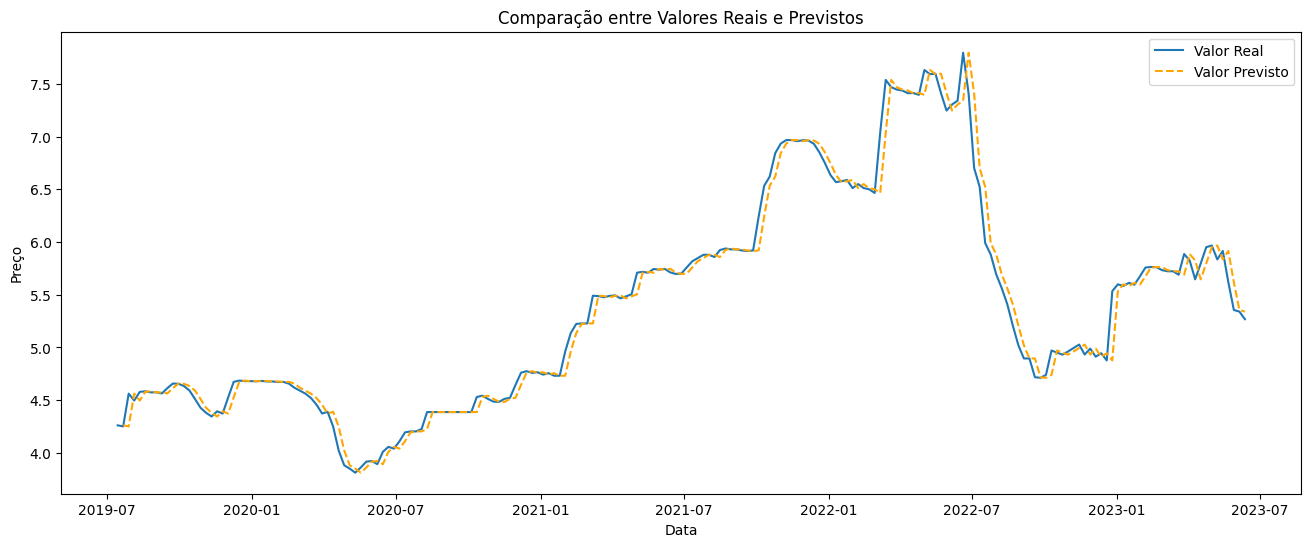

In [24]:
import pandas as pd

# Certifique-se de que os dados são numéricos e remova valores não numéricos
X_train_transformed_df = X_train_transformed_df.apply(pd.to_numeric, errors='coerce').dropna()
y_train = pd.to_numeric(y_train, errors='coerce').dropna()

# Combine os dados de treino e validação para formar uma série contínua
X_combined_df = pd.concat([X_train_transformed_df, X_val_transformed_df])
y_combined = pd.concat([y_train, y_val])

# Função de previsão Random Walk para o conjunto de validação
def random_walk_forecast(series):
    # Previsão do Random Walk: a previsão para cada ponto é o valor imediatamente anterior
    return series.shift(1)

# Aplicar a previsão no conjunto combinado
y_combined_forecast = random_walk_forecast(y_combined)

# Selecionar apenas as previsões para o conjunto de validação
y_forecast = y_combined_forecast.loc[y_combined.index]

# Exibir as previsões para o conjunto de validação
print("Previsões de Random Walk para o conjunto de validação:")
plt.figure(figsize=(16, 6))
plt.plot(y_combined, label='Valor Real')
plt.plot(y_forecast, label='Valor Previsto', linestyle='--', color='orange')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

# Calcule os resíduos para o conjunto de validação
residuos_val = y_combined.loc[y_forecast.index] - y_forecast





In [25]:
# Calcular resíduos (erro entre a série original e a previsão)
residuos_val = y_combined - y_combined_forecast

# Construir variáveis lagged para previsão
# `X_residual` será o resíduo defasado em um ponto e `y_residual` será o resíduo atual
X_residual = residuos_val.shift(1).dropna()
y_residual = residuos_val.loc[X_residual.index]

# Escalar os dados para manter consistência com o modelo anterior
scaler_residual = StandardScaler()
X_residual_scaled = scaler_residual.fit_transform(X_residual.values.reshape(-1, 1))

# Configurar busca Bayesiana para o modelo ajustado de resíduos
bayes_search_residual = BayesSearchCV(
    RidgeSGDKernelTorch(),
    param_space,
    n_iter=30,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Realizar a busca Bayesiana para encontrar os melhores parâmetros para o modelo de resíduos
bayes_search_residual.fit(X_residual_scaled, y_residual)
best_model_residual = bayes_search_residual.best_estimator_

# Realizar previsão para os resíduos utilizando o modelo treinado
y_residual_forecast = []
for x_new, y_actual in zip(X_residual_scaled, y_residual):
    # Prever o próximo resíduo
    y_pred = best_model_residual.predict(x_new).item()
    y_residual_forecast.append(y_pred)
    
    # Atualizar o modelo com o valor real
    best_model_residual.partial_fit(x_new, y_actual)

# Converter previsões de resíduos para uma série com o mesmo índice de `y_residual`
y_residual_forecast_series = pd.Series(y_residual_forecast, index=y_residual.index)

# Exibir as previsões dos resíduos e calcular o MSE
mse_residual = mean_squared_error(y_residual, y_residual_forecast_series)
print("Mean Squared Error para a previsão dos resíduos:", mse_residual)
print("Previsões dos resíduos:")
print(y_residual_forecast_series)


KeyboardInterrupt: 

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

# Suponha que você tenha os resíduos (y_residual) e um índice de tempo
y_residual_forecast = []
y_residual = pd.Series(residuos_val)  # Substitua pelos seus resíduos

# Aqui, assumimos que a série de resíduos começa a partir de algum ponto e é usada para treinamento incremental
for i in range(2, len(y_residual)):  # Iniciamos de 2 para garantir que há dados suficientes para ARIMA(1,1,1)
    train_data = y_residual[:i]  # Dados de treino até o ponto atual (excluindo a observação atual)
    
    # Ajustar o modelo ARIMA(1,1,1) com os dados de treino
    model_arima = ARIMA(train_data, order=(1, 1, 1))
    model_arima_fit = model_arima.fit()
    
    # Prever o próximo valor
    y_pred = model_arima_fit.forecast(steps=1)  # Retorna uma lista de previsões
    y_residual_forecast.append(y_pred[0])  # Pegamos o primeiro valor da lista de previsões
    
    # Atualizar a série de resíduos com o valor real (em uma aplicação real, aqui seria o valor real de y_residual[i])
    y_actual = y_residual.iloc[i]  # Acessa o valor real com iloc (por posição)
    
    # Atualizando a série de resíduos com o valor real, adicionando uma nova data sequencial
    y_residual = pd.concat([y_residual, pd.Series([y_actual], index=[y_residual.index[-1] + pd.Timedelta(1, unit='D')])])

# Converter previsões de resíduos para uma série com o mesmo índice de `y_residual`
y_residual_forecast_series = pd.Series(y_residual_forecast, index=y_residual.index[2:])

# Exibir as previsões dos resíduos
print("Previsões dos resíduos:")
print(y_residual_forecast_series)

# Calcular o erro quadrático médio (MSE) na escala original
mse_residual_original = mean_squared_error(y_residual[2:], y_residual_forecast_series)
print("Mean Squared Error (MSE) para a previsão dos resíduos:", mse_residual_original)


c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kaio\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to es

KeyError: 0

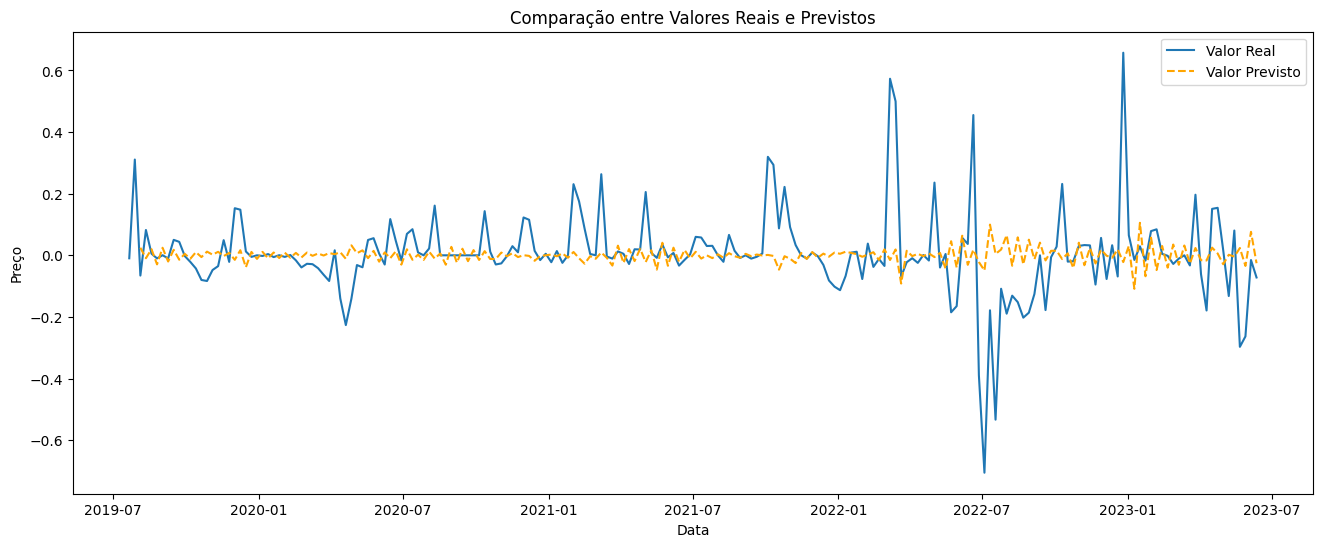

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(residuos_val, label='Valor Real')
plt.plot(y_residual_forecast_series, label='Valor Previsto', linestyle='--', color='orange')
plt.title('Comparação entre Valores Reais e Previstos')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()


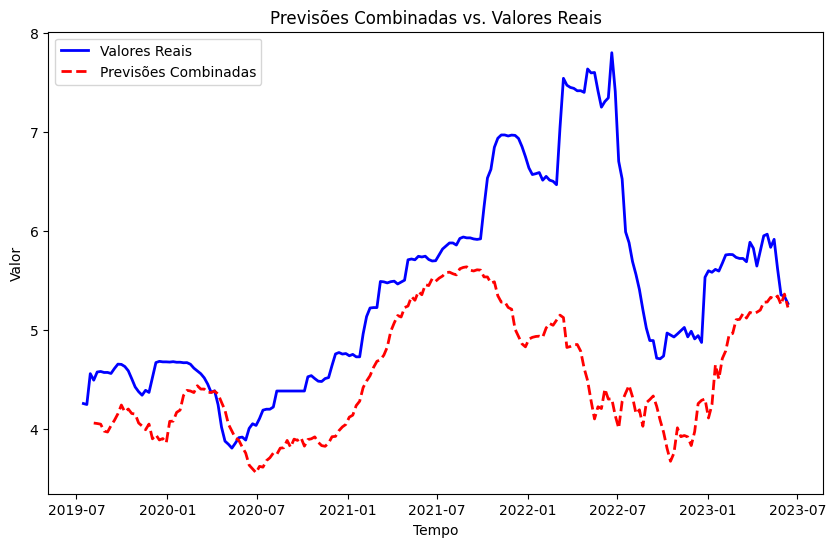

In [ ]:
import matplotlib.pyplot as plt

# Somar as previsões de `y_combined_forecast` com as previsões dos resíduos
# Aqui, `y_combined_forecast` é a previsão original e `y_residual_forecast_series` é a previsão dos resíduos
y_pred_combined = y_pred_combined_series + y_residual_forecast_original_serie

# Gerar o gráfico comparando as previsões combinadas com os valores reais (y_combined)
plt.figure(figsize=(10, 6))

# Plotar os valores reais da série original
plt.plot(y_combined.index, y_combined, label='Valores Reais', color='blue', linestyle='-', linewidth=2)

# Plotar as previsões combinadas
plt.plot(y_combined.index, y_pred_combined, label='Previsões Combinadas', color='red', linestyle='--', linewidth=2)

# Títulos e rótulos
plt.title('Previsões Combinadas vs. Valores Reais')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Exibir o gráfico


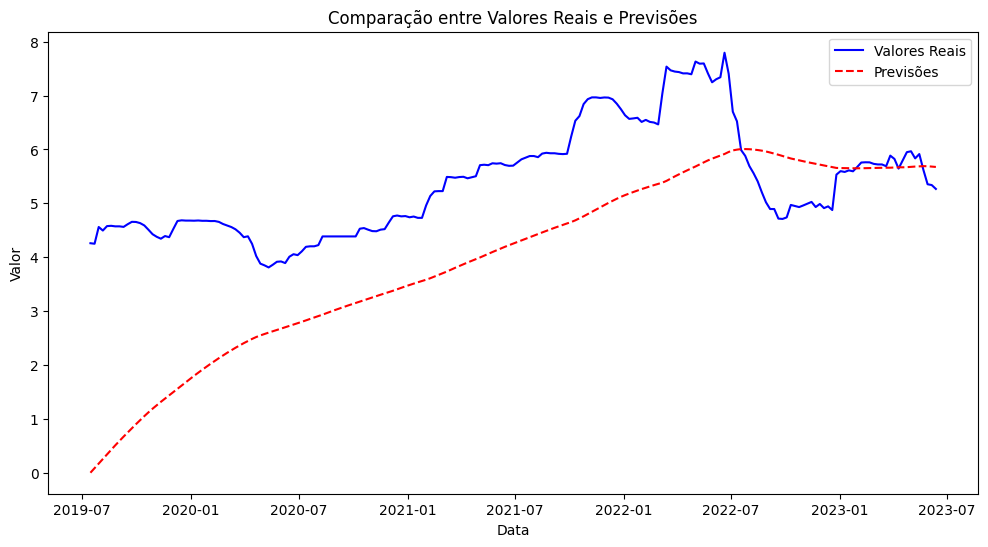

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from river import linear_model, preprocessing, metrics

# Converta os dados para numéricos e remova valores não numéricos
X_train_transformed_df = X_train_transformed_df.apply(pd.to_numeric, errors='coerce').dropna()
y_train = pd.to_numeric(y_train, errors='coerce').dropna()

# Combine os dados de treino e validação
X_combined_df = pd.concat([X_train_transformed_df, X_val_transformed_df])
y_combined = pd.concat([y_train, y_val])

# Inicializar o scaler e o modelo de regressão linear
scaler = preprocessing.StandardScaler()
model = linear_model.LinearRegression()
metric = metrics.MAE()

# Lista para armazenar as previsões
y_pred_combined = []

# Treinamento online do modelo e armazenamento das previsões
for x, y in zip(X_combined_df.to_dict(orient="records"), y_combined):
    # Padronizar os dados online
    x = scaler.transform_one(x)
    # Fazer a predição
    y_pred = model.predict_one(x)
    # Armazenar a predição na lista
    y_pred_combined.append(y_pred)
    # Atualizar a métrica e o modelo
    metric.update(y, y_pred)
    model.learn_one(x, y)

# Converter as previsões para uma série para preservar o índice
y_pred_combined_series = pd.Series(y_pred_combined, index=y_combined.index)

# Plotar os valores reais e as previsões
plt.figure(figsize=(12, 6))
plt.plot(y_combined.index, y_combined, label="Valores Reais", color="blue")
plt.plot(y_pred_combined_series.index, y_pred_combined_series, label="Previsões", color="red", linestyle="--")
plt.xlabel("Data")
plt.ylabel("Valor")
plt.title("Comparação entre Valores Reais e Previsões")
plt.legend()
plt.show()
